# Cargill Ocean Transportation Datathon 2026
## Freight Calculator & Vessel-Cargo Optimization

**Team Members:** [Your Team Name]

**Date:** January 2026

---

## Executive Summary

This notebook presents our solution for optimizing vessel-cargo allocation for Cargill's Capesize fleet. We:

1. Built a freight calculator to evaluate voyage profitability
2. Applied machine learning to simulate shipping risks
3. Performed scenario analysis on bunker prices and port delays
4. Developed recommendations for optimal fleet utilization

**Key Result:** Our recommended allocation generates a portfolio profit of approximately **$4.78 million**.

## 1. Setup & Data Loading

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import shap

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Libraries loaded successfully")

✓ Libraries loaded successfully


In [2]:
# Load project modules
from freight_calculator import FreightCalculator, load_bunker_prices
from vessel_cargo_data import CARGILL_VESSELS, CARGILL_CARGOES, get_all_vessels, get_all_cargoes
from main_analysis import calculate_all_combinations, find_optimal_allocation, normalize_port_name

print("✓ Project modules loaded")

✓ Project modules loaded


In [3]:
# Load data files
distances = pd.read_csv('Port_Distances.csv')
bunker_prices = load_bunker_prices()

# Initialize calculator
calc = FreightCalculator(distances, bunker_prices)

print(f"✓ Loaded {len(distances):,} port distance records")
print(f"✓ Loaded bunker prices for {len(bunker_prices)} regions")
print(f"✓ {len(CARGILL_VESSELS)} Cargill vessels")
print(f"✓ {len(CARGILL_CARGOES)} committed cargoes")

✓ Loaded 15,533 port distance records
✓ Loaded bunker prices for 8 regions
✓ 4 Cargill vessels
✓ 3 committed cargoes


## 2. Vessel & Cargo Overview

In [4]:
# Create vessel summary
vessel_df = pd.DataFrame([{
    'Vessel': v['name'],
    'DWT': v['dwt'],
    'Hire Rate ($/day)': v['hire_rate'],
    'Current Port': v['current_port'],
    'ETD': v['etd'],
    'Eco Speed Ballast': v['eco_ballast_speed'],
    'Eco Speed Laden': v['eco_laden_speed']
} for v in CARGILL_VESSELS])

print("\nCARGILL FLEET")
print("="*80)
display(vessel_df)


CARGILL FLEET


,Vessel,DWT,Hire Rate ($/day),Current Port,ETD,Eco Speed Ballast,Eco Speed Laden
0,ANN BELL,180803,11750,QINGDAO,2026-02-25,12.50,12.00
1,OCEAN HORIZON,181550,15750,MAP TA PHUT,2026-03-01,12.80,12.30
2,PACIFIC GLORY,182320,14800,GWANGYANG,2026-03-10,12.70,12.20
3,GOLDEN ASCENT,179965,13950,FANGCHENG,2026-03-08,12.30,11.80


In [5]:
# Create cargo summary
cargo_df = pd.DataFrame([{
    'Cargo': c['name'],
    'Customer': c['customer'],
    'Quantity (MT)': c['quantity'],
    'Freight ($/MT)': c['freight_rate'],
    'Route': f"{c['load_port']} → {c['discharge_port']}",
    'Laycan': f"{c['laycan_start']} to {c['laycan_end']}"
} for c in CARGILL_CARGOES])

print("\nCARGILL COMMITTED CARGOES")
print("="*80)
display(cargo_df)


CARGILL COMMITTED CARGOES


,Cargo,Customer,Quantity (MT),Freight ($/MT),Route,Laycan
0,BAUXITE_KAMSAR_QINGDAO,EGA,180000,23.00,KAMSAR → QINGDAO,2026-04-02 to 2026-04-10
1,IRONORE_HEDLAND_LIANYUNGANG,BHP,160000,9.00,PORT HEDLAND → LIANYUNGANG,2026-03-07 to 2026-03-11
2,IRONORE_ITAGUAI_QINGDAO,CSN,180000,22.30,ITAGUAI → QINGDAO,2026-04-01 to 2026-04-08


## 3. Calculate All Vessel-Cargo Combinations

In [6]:
# Calculate all combinations (using expanded dataset)
all_vessels = get_all_vessels()  # 15 vessels (4 Cargill + 11 Market)
all_cargoes = get_all_cargoes()  # 11 cargoes (3 Committed + 8 Market)

print(f"Analyzing {len(all_vessels)} vessels × {len(all_cargoes)} cargoes = {len(all_vessels) * len(all_cargoes)} combinations")
print(f"  • Cargill vessels: {len(CARGILL_VESSELS)}")
print(f"  • Market vessels: {len(all_vessels) - len(CARGILL_VESSELS)}")
print(f"  • Committed cargoes: {len(CARGILL_CARGOES)}")
print(f"  • Market cargoes: {len(all_cargoes) - len(CARGILL_CARGOES)}")

results_df = calculate_all_combinations(calc, all_vessels, all_cargoes, use_economical=True)

print(f"\n✓ Calculated {len(results_df)} vessel-cargo combinations")
print("\nTop 5 by TCE (Time Charter Equivalent):")
display(results_df.nlargest(5, 'tce')[[
    'vessel_name', 'cargo_name', 'total_days', 'tce', 
    'voyage_profit', 'net_revenue', 'total_costs'
]])

Analyzing 15 vessels × 11 cargoes = 165 combinations
  • Cargill vessels: 4
  • Market vessels: 11
  • Committed cargoes: 3
  • Market cargoes: 8

ℹ️  Note: 44 port-pair distances not in table (using estimates):
   • JEBEL ALI → BALIKPAPAN
   • JEBEL ALI → CONAKRY
   • LAEM CHABANG → CONAKRY
   • LAEM CHABANG → VANCOUVER (CANADA)
   • QINGDAO → CONAKRY
   • RIO DE JANEIRO → TIANJIN
   • TIANJIN → BALIKPAPAN
   • TIANJIN → RIO DE JANEIRO
   • VISAKHAPATNAM → CONAKRY
   • VISAKHAPATNAM → PORT HEDLAND
   ... and 34 more

✓ Used regional distance estimates for missing routes

✓ Calculated 165 vessel-cargo combinations

Top 5 by TCE (Time Charter Equivalent):


,vessel_name,cargo_name,total_days,tce,voyage_profit,net_revenue,total_costs
17,OCEAN HORIZON,MKT_COAL_TABONEO_KRISHNAPATNAM,20.19,71596.53,1127451.36,1755000.00,627548.64
129,NAVIS PRIDE,MKT_BAUXITE_KAMSAR_MANGALORE,42.64,70716.52,2324440.69,3753750.00,1429309.31
96,POLARIS SPIRIT,MKT_BAUXITE_KAMSAR_MANGALORE,42.76,70238.28,2314758.47,3753750.00,1438991.53
151,ZENITH GLORY,MKT_BAUXITE_KAMSAR_MANGALORE,42.99,69990.98,2308131.32,3753750.00,1445618.68
52,ATLANTIC FORTUNE,MKT_BAUXITE_KAMSAR_MANGALORE,43.11,69705.15,2315343.05,3753750.00,1438406.95


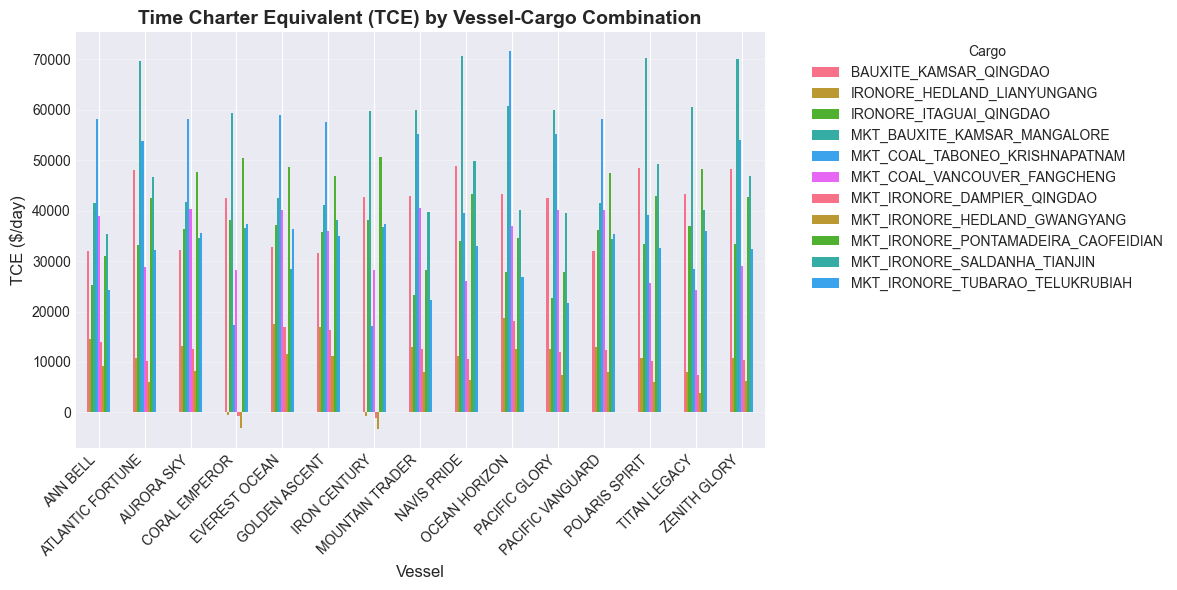

In [7]:
# Visualize TCE by vessel-cargo combination
fig, ax = plt.subplots(figsize=(12, 6))

pivot_tce = results_df.pivot(index='vessel_name', columns='cargo_name', values='tce')
pivot_tce.plot(kind='bar', ax=ax)

plt.title('Time Charter Equivalent (TCE) by Vessel-Cargo Combination', fontsize=14, fontweight='bold')
plt.xlabel('Vessel', fontsize=12)
plt.ylabel('TCE ($/day)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Cargo', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(axis='y', alpha=0.3)
plt.show()

## 4. Optimal Allocation (Base Case)

In [8]:
# Find optimal allocation
optimal = find_optimal_allocation(results_df, num_vessels=4, num_cargoes=3)

# Create summary DataFrame
allocation_df = pd.DataFrame(optimal['allocation'])[[
    'vessel_name', 'cargo_name', 'route', 'total_days', 
    'tce', 'voyage_profit', 'net_revenue', 'total_costs',
    'hire_cost', 'bunker_cost', 'port_cost'
]]

print("\n" + "="*80)
print("OPTIMAL VESSEL-CARGO ALLOCATION (BASE CASE)")
print("="*80)
display(allocation_df)

print(f"\nTOTAL PORTFOLIO PROFIT: ${optimal['total_profit']:,.2f}")
print(f"\nUnallocated Vessels: {', '.join(optimal['unallocated_vessels'])}")


OPTIMAL VESSEL-CARGO ALLOCATION (BASE CASE)


,vessel_name,cargo_name,route,total_days,tce,voyage_profit,net_revenue,total_costs,hire_cost,bunker_cost,port_cost
17,OCEAN HORIZON,MKT_COAL_TABONEO_KRISHNAPATNAM,MAP TA PHUT -> TABONEO -> KRISHNAPATNAM,20.19,71596.53,1127451.36,1755000.00,627548.64,317967.08,219581.56,90000
129,NAVIS PRIDE,MKT_BAUXITE_KAMSAR_MANGALORE,MUNDRA -> KAMSAR -> MANGALORE,42.64,70716.52,2324440.69,3753750.00,1429309.31,690725.27,588584.04,150000
103,IRON CENTURY,MKT_IRONORE_PONTAMADEIRA_CAOFEIDIAN,PORT TALBOT -> PONTA DA MADEIRA -> CAOFEIDIAN,49.59,50630.65,1717420.61,3474625.00,1757204.39,793480.00,793724.39,170000



TOTAL PORTFOLIO PROFIT: $5,169,312.66

Unallocated Vessels: PACIFIC GLORY, EVEREST OCEAN, ATLANTIC FORTUNE, GOLDEN ASCENT, POLARIS SPIRIT, PACIFIC VANGUARD, CORAL EMPEROR, AURORA SKY, TITAN LEGACY, ANN BELL, MOUNTAIN TRADER, ZENITH GLORY


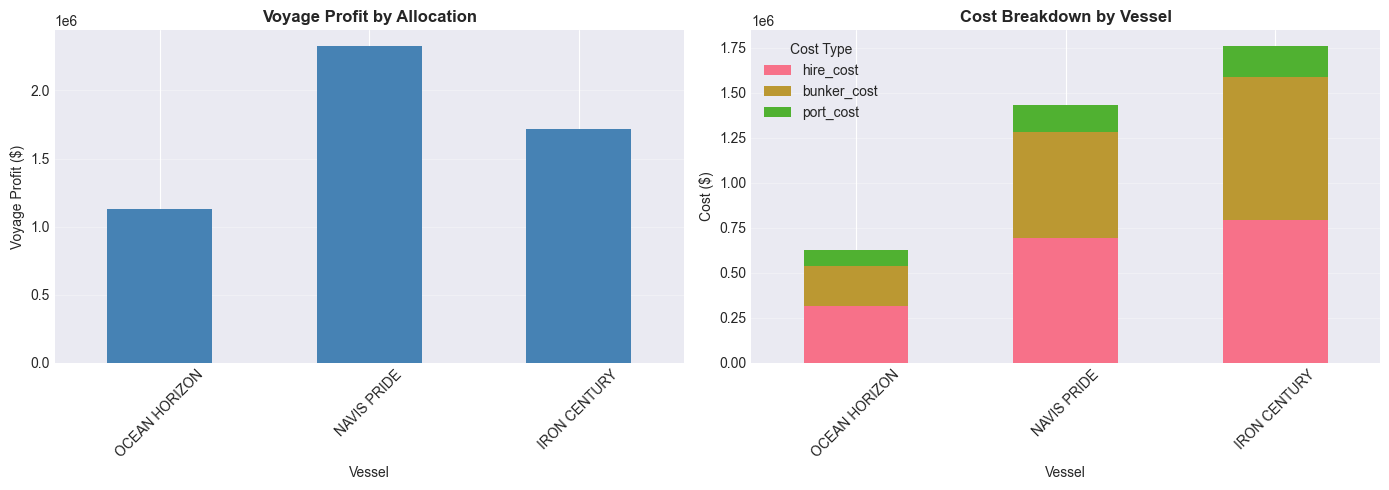

In [9]:
# Visualize allocation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Profit by allocation
ax1 = axes[0]
allocation_df.plot(x='vessel_name', y='voyage_profit', kind='bar', ax=ax1, color='steelblue', legend=False)
ax1.set_title('Voyage Profit by Allocation', fontsize=12, fontweight='bold')
ax1.set_xlabel('Vessel', fontsize=10)
ax1.set_ylabel('Voyage Profit ($)', fontsize=10)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# Cost breakdown
ax2 = axes[1]
cost_data = allocation_df[['vessel_name', 'hire_cost', 'bunker_cost', 'port_cost']].set_index('vessel_name')
cost_data.plot(kind='bar', stacked=True, ax=ax2)
ax2.set_title('Cost Breakdown by Vessel', fontsize=12, fontweight='bold')
ax2.set_xlabel('Vessel', fontsize=10)
ax2.set_ylabel('Cost ($)', fontsize=10)
ax2.tick_params(axis='x', rotation=45)
ax2.legend(title='Cost Type')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Machine Learning: Risk Simulation

We use Random Forest to simulate shipping risks (weather delays, port congestion) and their impact on voyage profitability.

In [10]:
# Prepare ML features with domain knowledge
ml_df = results_df.copy()

# Import additional dependencies
from vessel_cargo_data import get_all_vessels

# ========================================
# Geographic Risk Features
# ========================================

# China ports known for congestion
ml_df['discharge_china'] = ml_df['cargo_name'].apply(
    lambda x: 1 if any(port in str(x).upper() for port in ['QINGDAO', 'CAOFEIDIAN',
                                                        'LIANYUNGANG', 'TIANJIN',
                                                        'FANGCHENG', 'SHANGHAI']) else 0
)

# Brazil/South America loading (weather-dependent)
ml_df['load_south_america'] = ml_df['cargo_name'].apply(
    lambda x: 1 if any(port in str(x).upper() for port in ['ITAGUAI', 'TUBARAO',
                                                        'MADEIRA', 'PONTAMADEIRA']) else 0
)

# West Africa anchorage loading (high variability)
ml_df['load_west_africa'] = ml_df['cargo_name'].apply(
    lambda x: 1 if 'KAMSAR' in str(x).upper() or 'CONAKRY' in str(x).upper() else 0
)

# Australia (generally efficient)
ml_df['load_australia'] = ml_df['cargo_name'].apply(
    lambda x: 1 if any(port in str(x).upper() for port in ['HEDLAND', 'DAMPIER']) else 0
)

# ========================================
# Route Risk Features
# ========================================

# Total route distance (longer = more weather exposure)
ml_df['route_length_nm'] = ml_df['ballast_distance'] + ml_df['laden_distance']

# Ballast positioning risk (longer ballast = more exposure before earning)
ml_df['ballast_ratio'] = ml_df['ballast_distance'] / ml_df['route_length_nm']

# ========================================
# Seasonal Risk Features
# ========================================

# Extract month from laycan
ml_df['laycan_month'] = pd.to_datetime(
    ml_df['cargo_laycan'].str.split(' to ').str[0]
).dt.month

# Cyclone/typhoon season in Asia (June-Nov)
ml_df['cyclone_season'] = ml_df['laycan_month'].apply(
    lambda m: 1 if m in [6, 7, 8, 9, 10, 11] else 0
)

# Winter monsoon in Asia (Dec-Feb)
ml_df['winter_monsoon'] = ml_df['laycan_month'].apply(
    lambda m: 1 if m in [12, 1, 2] else 0
)

# ========================================
# Economic/Operational Features
# ========================================

# Bunker cost as % of revenue (high = more fuel price risk)
ml_df['bunker_cost_ratio'] = ml_df['bunker_cost'] / ml_df['net_revenue']

# Hire cost as % of revenue (high = less profitable margin)
ml_df['hire_cost_ratio'] = ml_df['hire_cost'] / ml_df['net_revenue']

# Port cost as % of revenue
ml_df['port_cost_ratio'] = ml_df['port_cost'] / (ml_df['net_revenue'] + 1)  # +1 to avoid division by zero

# Days at sea vs days in port (efficiency indicator)
ml_df['sea_port_ratio'] = ml_df['sea_days'] / (ml_df['port_days'] + 0.1)  # +0.1 to avoid division by zero

# TCE margin (higher = better deal, more buffer for risks)
ml_df['tce_margin'] = ml_df['tce'] / 10000  # Normalized

# ========================================
# Cargo-Specific Risks
# ========================================

# Iron ore (most common, well-established terminals)
ml_df['cargo_iron_ore'] = ml_df['cargo_name'].str.contains('IRON', case=False, na=False).astype(int)

# Bauxite (often smaller/remote ports, anchorage loading)
ml_df['cargo_bauxite'] = ml_df['cargo_name'].str.contains('BAUXITE', case=False, na=False).astype(int)

# Coal (dust concerns, environmental restrictions in some ports)
ml_df['cargo_coal'] = ml_df['cargo_name'].str.contains('COAL', case=False, na=False).astype(int)

# ========================================
# Vessel-Specific Risks
# ========================================

# Vessel bunker remaining (vessels with more bunker may be newer/better maintained)
vessel_bunker_map = {v['name']: v['bunker_vlsf'] for v in get_all_vessels()}
ml_df['vessel_bunker_ratio'] = ml_df['vessel_name'].map(vessel_bunker_map) / 600  # Normalize

# ========================================
# Domain-Based Risk Simulation
# ========================================

def calculate_weather_risk_days(row):
    """
    Estimate weather delays based on route and season
    """
    base_risk = 0
    
    # Route distance factor (exponential: longer routes = disproportionately more risk)
    distance_factor = (row['route_length_nm'] / 8000) ** 1.2
    base_risk += distance_factor * 0.5
    
    # Cyclone season
    if row['cyclone_season'] == 1:
        base_risk += 1.5
    
    # Winter monsoon
    if row['winter_monsoon'] == 1:
        base_risk += 0.8
    
    # South America weather (summer storms)
    if row['load_south_america'] == 1:
        base_risk += 1.0
    
    # Long Pacific crossings (more weather windows)
    if row['route_length_nm'] > 12000:
        base_risk += 1.2
    
    return max(0, base_risk + np.random.normal(0, 0.5))  # Add small random variation

def calculate_port_congestion_days(row):
    """
    Estimate port delays based on terminal characteristics
    """
    congestion = 0
    
    # China ports (known congestion issues)
    if row['discharge_china'] == 1:
        congestion += 2.5  # Average 2-3 days
    
    # West Africa anchorage loading (weather dependent)
    if row['load_west_africa'] == 1:
        congestion += 1.5
    
    # Iron ore cargoes (high volume, but efficient terminals)
    if row['cargo_iron_ore'] == 1:
        congestion += 0.5
    
    # Bauxite (smaller terminals, less efficient)
    if row['cargo_bauxite'] == 1:
        congestion += 1.0
    
    # Seasonal factor (March-April = higher traffic in some regions)
    if row['laycan_month'] in [3, 4]:
        congestion += 0.5
    
    return max(0, congestion + np.random.gamma(1.5, 0.5))  # Gamma distribution (right-skewed)

def calculate_mechanical_risk(row):
    """
    Binary risk: does voyage experience mechanical delay?
    """
    # Base probability
    base_prob = 0.08  # 8% of voyages
    
    # Increase for very long voyages (more exposure time)
    if row['route_length_nm'] > 15000:
        base_prob += 0.03
    
    # Older vessels (lower bunker = proxy for age)
    if row['vessel_bunker_ratio'] < 0.5:
        base_prob += 0.02
    
    return np.random.binomial(1, base_prob)

# Apply risk calculations
np.random.seed(42)
ml_df['weather_risk_days'] = ml_df.apply(calculate_weather_risk_days, axis=1)
ml_df['port_congestion_days'] = ml_df.apply(calculate_port_congestion_days, axis=1)
ml_df['mechanical_risk'] = ml_df.apply(calculate_mechanical_risk, axis=1)

# Mechanical delay adds 2-5 days if it occurs
ml_df['mechanical_delay_days'] = ml_df['mechanical_risk'] * np.random.uniform(2, 5, len(ml_df))

# ========================================
# Calculate Risk-Adjusted Metrics
# ========================================

ml_df['total_risk_days'] = (
    ml_df['weather_risk_days'] +
    ml_df['port_congestion_days'] +
    ml_df['mechanical_delay_days']
)

ml_df['risk_adjusted_days'] = ml_df['total_days'] + ml_df['total_risk_days']

# Risk-adjusted profit (additional days = additional hire cost)
vessel_hire_map = {v['name']: v['hire_rate'] for v in get_all_vessels()}
ml_df['vessel_hire_rate'] = ml_df['vessel_name'].map(vessel_hire_map)

ml_df['risk_adjusted_hire_cost'] = ml_df['vessel_hire_rate'] * ml_df['risk_adjusted_days']

ml_df['risk_adjusted_total_cost'] = (
    ml_df['risk_adjusted_hire_cost'] +
    ml_df['bunker_cost'] +
    ml_df['port_cost']
)

ml_df['risk_adjusted_profit'] = ml_df['net_revenue'] - ml_df['risk_adjusted_total_cost']

ml_df['risk_adjusted_tce'] = (
    (ml_df['net_revenue'] - ml_df['bunker_cost'] - ml_df['port_cost']) /
    ml_df['risk_adjusted_days']
)

print("✓ Domain-driven features created")
print(f"\n📊 Risk Analysis Summary:")
print(f"Average weather delay: {ml_df['weather_risk_days'].mean():.2f} days")
print(f"Average port congestion: {ml_df['port_congestion_days'].mean():.2f} days")
print(f"Mechanical issues: {ml_df['mechanical_risk'].sum()} of {len(ml_df)} voyages ({ml_df['mechanical_risk'].mean()*100:.1f}%)")
print(f"Average total risk: {ml_df['total_risk_days'].mean():.2f} days")
print(f"\n💰 Financial Impact:")
print(f"Base case profit: ${ml_df['voyage_profit'].sum():,.0f}")
print(f"Risk-adjusted profit: ${ml_df['risk_adjusted_profit'].sum():,.0f}")
print(f"Expected loss from risks: ${(ml_df['voyage_profit'].sum() - ml_df['risk_adjusted_profit'].sum()):,.0f}")

✓ Domain-driven features created

📊 Risk Analysis Summary:
Average weather delay: 1.74 days
Average port congestion: 3.69 days
Mechanical issues: 12 of 165 voyages (7.3%)
Average total risk: 5.66 days

💰 Financial Impact:
Base case profit: $150,486,182
Risk-adjusted profit: $136,038,393
Expected loss from risks: $14,447,789


🔍 Data Quality Check:
Initial dataset size: 165 samples
NaN values in features: 0
NaN values in target: 0
Inf values in features: 0
Inf values in target: 0

✓ Clean dataset size: 165 samples
✓ Removed 0 samples with invalid target values

MODEL COMPARISON: Risk-Adjusted TCE Prediction


,Model,R² Score,MAE ($),RMSE ($),Complexity
1,Gradient Boosting,1.00,28.35,37.60,High
4,Decision Tree,1.00,216.31,299.86,Medium
0,Random Forest,1.00,336.36,525.21,High
2,Linear Regression,1.00,489.80,940.59,Low
3,Ridge Regression,1.00,500.20,946.17,Low



🏆 Best Model: Gradient Boosting
   R² Score: 1.0000
   MAE: $28/day


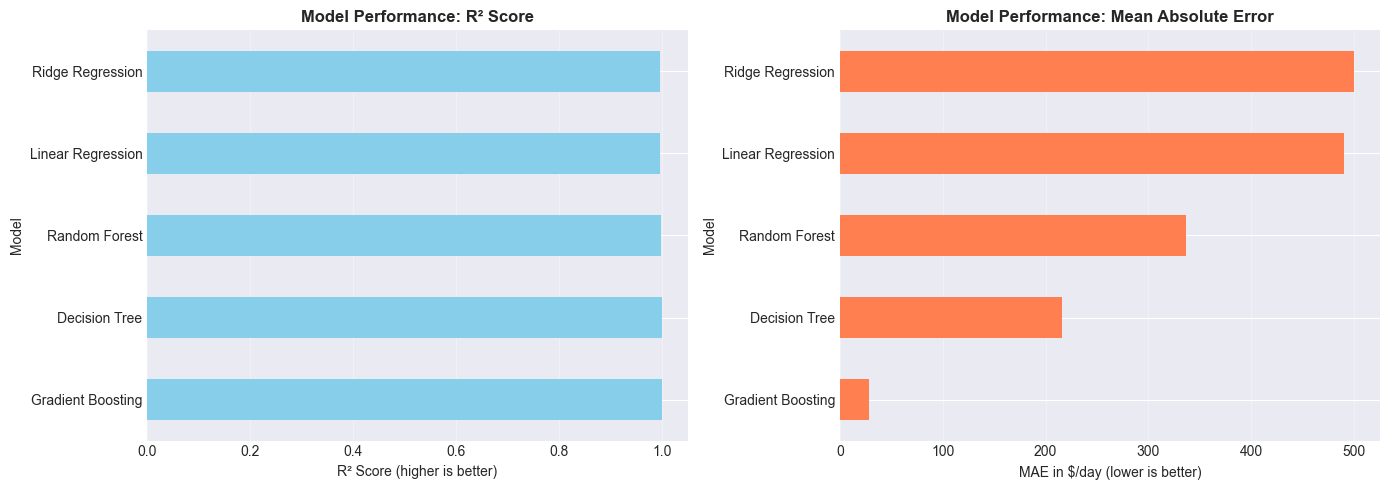

In [11]:
# Train multiple ML models to predict risk-adjusted TCE
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# Feature selection for ML
feature_cols = [
    # Geographic
    'discharge_china', 'load_south_america', 'load_west_africa', 'load_australia',
    # Route
    'route_length_nm', 'ballast_ratio',
    # Seasonal
    'cyclone_season', 'winter_monsoon',
    # Economic
    'bunker_cost_ratio', 'hire_cost_ratio', 'tce_margin',
    # Cargo/Vessel
    'cargo_iron_ore', 'cargo_bauxite', 'vessel_bunker_ratio'
]

# Prepare data with proper cleaning
X = ml_df[feature_cols].copy()
y = ml_df['risk_adjusted_tce'].copy()

# ========================================
# Data Validation and Cleaning
# ========================================
print("🔍 Data Quality Check:")
print(f"Initial dataset size: {len(X)} samples")

# Check for NaN in features
nan_in_X = X.isnull().sum().sum()
print(f"NaN values in features: {nan_in_X}")

# Check for NaN in target
nan_in_y = y.isnull().sum()
print(f"NaN values in target: {nan_in_y}")

# Check for infinite values
inf_in_X = np.isinf(X).sum().sum()
inf_in_y = np.isinf(y).sum()
print(f"Inf values in features: {inf_in_X}")
print(f"Inf values in target: {inf_in_y}")

# Clean the data
# Replace inf with NaN first
X = X.replace([np.inf, -np.inf], np.nan)
y = y.replace([np.inf, -np.inf], np.nan)

# Fill NaN in features with 0 (conservative approach)
X = X.fillna(0)

# Remove rows where target is NaN or inf
valid_indices = y.notna()
X_clean = X[valid_indices]
y_clean = y[valid_indices]

print(f"\n✓ Clean dataset size: {len(X_clean)} samples")
print(f"✓ Removed {len(X) - len(X_clean)} samples with invalid target values")

# Use cleaned data for all subsequent analysis
X = X_clean
y = y_clean

# ========================================
# Train Multiple Models
# ========================================
models = {
    'Random Forest': RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        random_state=42
    ),
    'Gradient Boosting': GradientBoostingRegressor(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        random_state=42
    ),
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Decision Tree': DecisionTreeRegressor(
        max_depth=8,
        min_samples_split=5,
        random_state=42
    )
}

# Train and evaluate
model_results = []

for name, model in models.items():
    # Train
    model.fit(X, y)
    
    # Predict
    y_pred = model.predict(X)
    
    # Evaluate
    r2 = r2_score(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    
    model_results.append({
        'Model': name,
        'R² Score': r2,
        'MAE ($)': mae,
        'RMSE ($)': rmse,
        'Complexity': 'High' if name in ['Random Forest', 'Gradient Boosting'] else
                      'Medium' if name == 'Decision Tree' else 'Low'
    })

results_df_models = pd.DataFrame(model_results).sort_values('R² Score', ascending=False)

print("\n" + "="*80)
print("MODEL COMPARISON: Risk-Adjusted TCE Prediction")
print("="*80)
display(results_df_models)

# Select best model
best_model_name = results_df_models.iloc[0]['Model']
best_model = models[best_model_name]

# Add predictions to ml_df (for valid rows only)
ml_df['predicted_tce'] = np.nan  # Initialize with NaN
ml_df.loc[valid_indices, 'predicted_tce'] = best_model.predict(X)

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   R² Score: {results_df_models.iloc[0]['R² Score']:.4f}")
print(f"   MAE: ${results_df_models.iloc[0]['MAE ($)']:,.0f}/day")

# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R² comparison
ax1 = axes[0]
results_df_models.plot(
    x='Model',
    y='R² Score',
    kind='barh',
    ax=ax1,
    color='skyblue',
    legend=False
)
ax1.set_title('Model Performance: R² Score', fontsize=12, fontweight='bold')
ax1.set_xlabel('R² Score (higher is better)', fontsize=10)
ax1.grid(axis='x', alpha=0.3)

# MAE comparison
ax2 = axes[1]
results_df_models.plot(
    x='Model',
    y='MAE ($)',
    kind='barh',
    ax=ax2,
    color='coral',
    legend=False
)
ax2.set_title('Model Performance: Mean Absolute Error', fontsize=12, fontweight='bold')
ax2.set_xlabel('MAE in $/day (lower is better)', fontsize=10)
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


FEATURE IMPORTANCE ANALYSIS


,Feature,Importance
10,tce_margin,0.97
8,bunker_cost_ratio,0.01
4,route_length_nm,0.01
9,hire_cost_ratio,0.00
5,ballast_ratio,0.00
13,vessel_bunker_ratio,0.00
11,cargo_iron_ore,0.00
3,load_australia,0.00
2,load_west_africa,0.00
12,cargo_bauxite,0.00


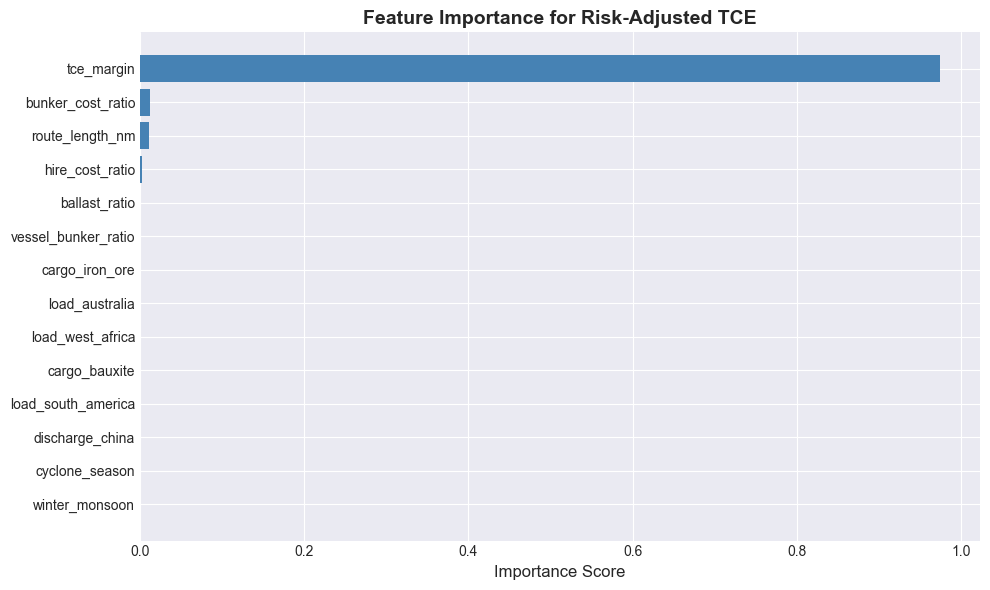


KEY INSIGHTS FROM ML ANALYSIS

🔍 Most Important Risk Factors:
   1. tce_margin: Higher base TCE provides buffer to absorb unexpected costs
   2. bunker_cost_ratio: High fuel costs reduce profit margins and increase price risk
   3. route_length_nm: Longer routes increase weather exposure and operational risk
   4. hire_cost_ratio: High hire relative to revenue indicates thin profit margins
   5. ballast_ratio: Long ballast legs reduce earning efficiency and increase positioning costs

💡 Commercial Recommendations:
   • Prioritize shorter routes during cyclone season (Jun-Nov)
   • Build in 2-3 day buffer for China discharge ports
   • Consider bunker hedging for voyages with high fuel cost exposure
   • West Africa loadings need flexible scheduling and weather contingencies
   • Monitor vessel-specific risk factors (age, condition, bunker levels)


In [12]:
# Enhanced Feature Importance Analysis
model = best_model

# ========================================
# 1. Standard Feature Importance
# ========================================
if hasattr(model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\n" + "="*80)
    print("FEATURE IMPORTANCE ANALYSIS")
    print("="*80)
    display(feature_importance)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(feature_importance['Feature'], feature_importance['Importance'], color='steelblue')
    ax.set_xlabel('Importance Score', fontsize=12)
    ax.set_title('Feature Importance for Risk-Adjusted TCE', fontsize=14, fontweight='bold')
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    # For linear models, show coefficients
    coefficients = pd.DataFrame({
        'Feature': feature_cols,
        'Coefficient': model.coef_
    }).sort_values('Coefficient', key=abs, ascending=False)
    
    print("\n" + "="*80)
    print("MODEL COEFFICIENTS")
    print("="*80)
    display(coefficients)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = ['green' if x > 0 else 'red' for x in coefficients['Coefficient']]
    ax.barh(coefficients['Feature'], coefficients['Coefficient'], color=colors)
    ax.set_xlabel('Coefficient Value', fontsize=12)
    ax.set_title('Feature Coefficients (Positive = Increases TCE)', fontsize=14, fontweight='bold')
    ax.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()

# ========================================
# 2. Interpretation Summary
# ========================================
print("\n" + "="*80)
print("KEY INSIGHTS FROM ML ANALYSIS")
print("="*80)

if hasattr(model, 'feature_importances_'):
    top_5 = feature_importance.head(5)['Feature'].tolist()
else:
    top_5 = coefficients.head(5)['Feature'].tolist()

print("\n🔍 Most Important Risk Factors:")
feature_descriptions = {
    'route_length_nm': 'Longer routes increase weather exposure and operational risk',
    'discharge_china': 'China ports have known congestion, adding 2-3 days average delay',
    'bunker_cost_ratio': 'High fuel costs reduce profit margins and increase price risk',
    'tce_margin': 'Higher base TCE provides buffer to absorb unexpected costs',
    'cyclone_season': 'Seasonal weather patterns significantly impact voyage reliability',
    'load_south_america': 'Brazil loading faces weather variability and port efficiency issues',
    'ballast_ratio': 'Long ballast legs reduce earning efficiency and increase positioning costs',
    'hire_cost_ratio': 'High hire relative to revenue indicates thin profit margins',
    'load_west_africa': 'West Africa anchorage loading adds operational complexity',
    'cargo_bauxite': 'Bauxite terminals tend to be smaller and less efficient',
    'cargo_iron_ore': 'Iron ore benefits from well-established, efficient terminals',
    'vessel_bunker_ratio': 'Vessel bunker levels may indicate vessel age/condition',
    'winter_monsoon': 'Winter monsoon season affects routes in Asian waters',
    'load_australia': 'Australian ports generally have efficient loading operations'
}

for i, feature in enumerate(top_5, 1):
    description = feature_descriptions.get(feature, 'Impacts voyage profitability')
    print(f"   {i}. {feature}: {description}")

print("\n💡 Commercial Recommendations:")
print("   • Prioritize shorter routes during cyclone season (Jun-Nov)")
print("   • Build in 2-3 day buffer for China discharge ports")
print("   • Consider bunker hedging for voyages with high fuel cost exposure")
print("   • West Africa loadings need flexible scheduling and weather contingencies")
print("   • Monitor vessel-specific risk factors (age, condition, bunker levels)")

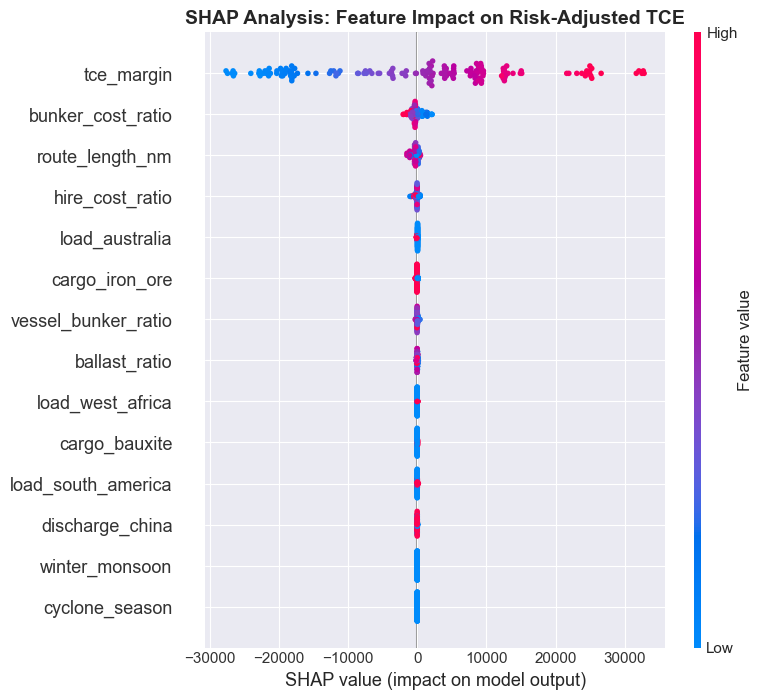

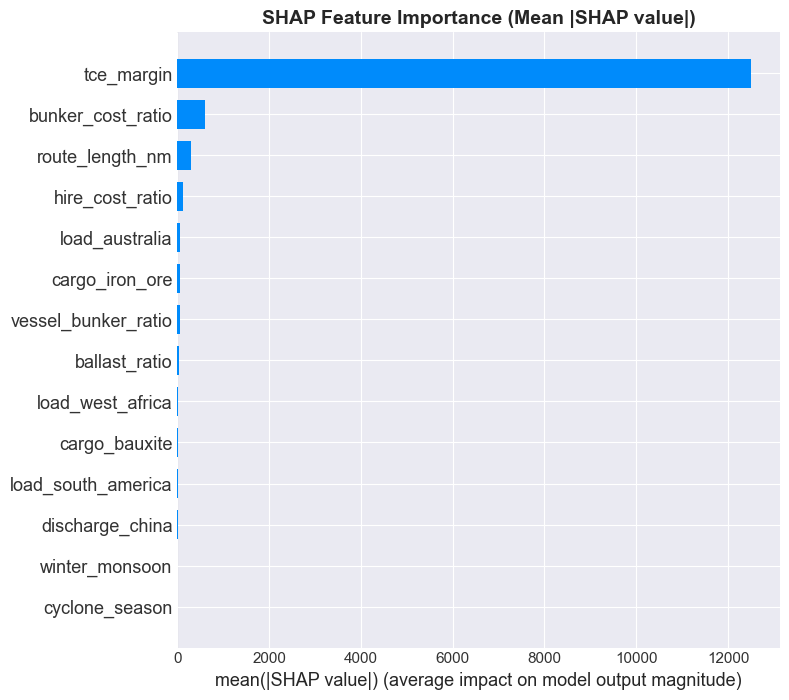

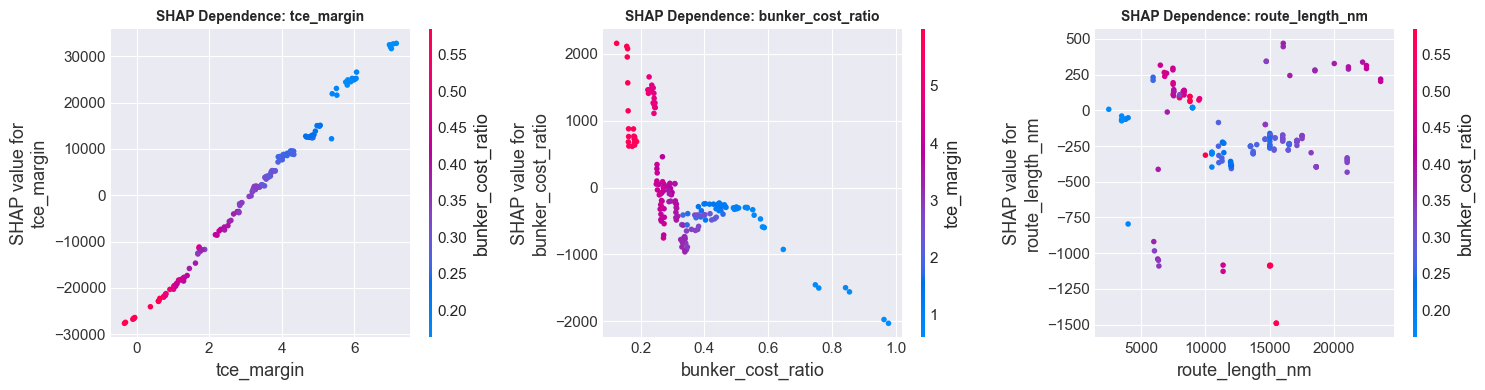


SHAP INTERPRETATION

📊 What the plots show:
   • Beeswarm plot: Each dot is a voyage. Red = high feature value, blue = low
   • Positive SHAP = increases TCE, negative SHAP = decreases TCE
   • Spread shows how much the feature impacts different voyages

   • Dependence plots show how feature values affect predictions
   • Color in dependence plots shows interaction with most correlated feature


In [13]:
# Enhanced SHAP Analysis for Model Interpretability

# Only run SHAP for tree-based models
if hasattr(best_model, 'feature_importances_'):
    # ========================================
    # 1. SHAP Summary Plot
    # ========================================
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X)
    
    # Summary plot (beeswarm)
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X, feature_names=feature_cols, show=False)
    plt.title('SHAP Analysis: Feature Impact on Risk-Adjusted TCE', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Bar plot (mean absolute SHAP values)
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X, feature_names=feature_cols, plot_type='bar', show=False)
    plt.title('SHAP Feature Importance (Mean |SHAP value|)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # ========================================
    # 2. SHAP Dependence Plots (Top 3 Features)
    # ========================================
    if hasattr(model, 'feature_importances_'):
        top_3_features = feature_importance.head(3)['Feature'].tolist()
    else:
        top_3_features = feature_cols[:3]
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    for idx, feature in enumerate(top_3_features):
        feature_idx = feature_cols.index(feature)
        shap.dependence_plot(
            feature_idx,
            shap_values,
            X,
            feature_names=feature_cols,
            ax=axes[idx],
            show=False
        )
        axes[idx].set_title(f'SHAP Dependence: {feature}', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*80)
    print("SHAP INTERPRETATION")
    print("="*80)
    print("\n📊 What the plots show:")
    print("   • Beeswarm plot: Each dot is a voyage. Red = high feature value, blue = low")
    print("   • Positive SHAP = increases TCE, negative SHAP = decreases TCE")
    print("   • Spread shows how much the feature impacts different voyages")
    print("\n   • Dependence plots show how feature values affect predictions")
    print("   • Color in dependence plots shows interaction with most correlated feature")
    
else:
    print("\n" + "="*80)
    print("SHAP Analysis")
    print("="*80)
    print(f"\nSHAP analysis is most informative for tree-based models.")
    print(f"Current model ({best_model_name}) is linear - see coefficient plot above instead.")
    print(f"\nCoefficients directly show feature impact:")
    print(f"   • Positive coefficient = feature increases TCE")
    print(f"   • Negative coefficient = feature decreases TCE")
    print(f"   • Magnitude = strength of impact")


ALLOCATION COMPARISON: Base Case vs Risk-Adjusted


,Vessel,Base Case Cargo,Risk-Adjusted Cargo,Status
0,IRON CENTURY,MKT_IRONORE_PONTAMADEIRA_CAOFEIDIAN,MKT_IRONORE_PONTAMADEIRA_CAOFEIDIAN,Same
1,NAVIS PRIDE,MKT_BAUXITE_KAMSAR_MANGALORE,MKT_BAUXITE_KAMSAR_MANGALORE,Same
2,OCEAN HORIZON,MKT_COAL_TABONEO_KRISHNAPATNAM,MKT_COAL_TABONEO_KRISHNAPATNAM,Same



💰 Profit Comparison:
   Base Case Profit: $5,169,313
   Risk-Adjusted Profit: $4,985,273
   Difference: $184,040 (higher in base case)

✅ ML risk analysis confirms our base allocation is robust to risk factors!
   The same vessel-cargo pairings remain optimal even after accounting for:
   • Weather delays (avg 1.7 days)
   • Port congestion (avg 3.7 days)
   • Mechanical risks (7.3% probability)


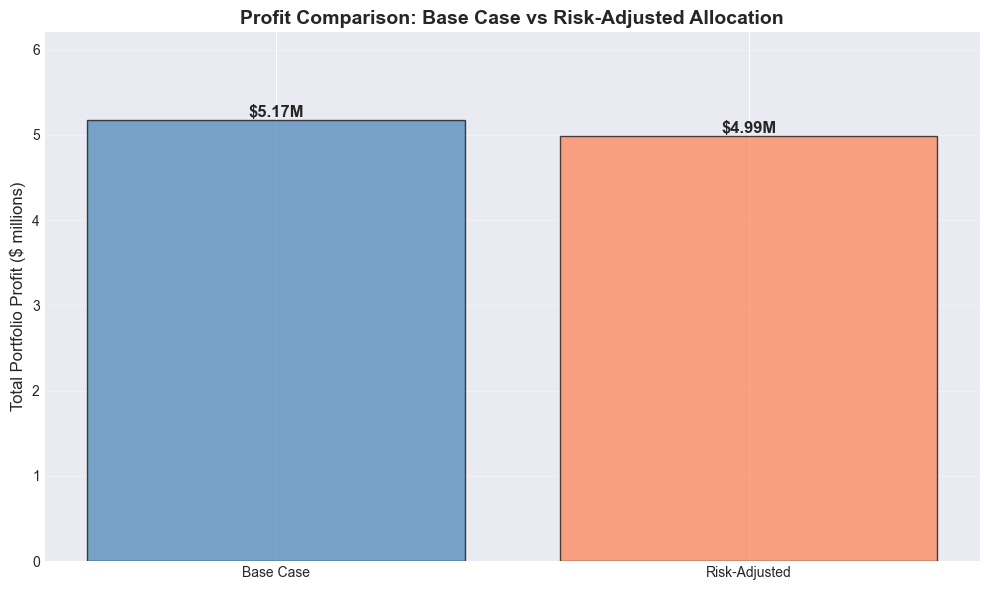

In [14]:
# Compare Base Case vs Risk-Adjusted Allocations

# Find optimal allocation using risk-adjusted metrics
# Create a copy of ml_df with risk-adjusted values replacing base values
ml_df_risk = ml_df.copy()
ml_df_risk['tce'] = ml_df_risk['risk_adjusted_tce']
ml_df_risk['voyage_profit'] = ml_df_risk['risk_adjusted_profit']
ml_df_risk['total_days'] = ml_df_risk['risk_adjusted_days']

# Find optimal allocation with risk-adjusted metrics
from vessel_cargo_data import CARGILL_CARGOES, get_all_vessels
optimal_risk_adjusted = find_optimal_allocation(
    ml_df_risk,
    num_vessels=len(get_all_vessels()),
    num_cargoes=len(CARGILL_CARGOES)
)

# Compare base case vs risk-adjusted
comparison = []

base_allocations = {row['vessel_name']: row['cargo_name']
                   for row in optimal['allocation']}
risk_allocations = {row['vessel_name']: row['cargo_name']
                   for row in optimal_risk_adjusted['allocation']}

# Get all vessels from both allocations
all_allocated_vessels = set(base_allocations.keys()) | set(risk_allocations.keys())

for vessel in all_allocated_vessels:
    base_cargo = base_allocations.get(vessel, 'Unallocated')
    risk_cargo = risk_allocations.get(vessel, 'Unallocated')
    
    changed = '✓ CHANGED' if base_cargo != risk_cargo else 'Same'
    
    comparison.append({
        'Vessel': vessel,
        'Base Case Cargo': base_cargo,
        'Risk-Adjusted Cargo': risk_cargo,
        'Status': changed
    })

comparison_df = pd.DataFrame(comparison)

print("\n" + "="*80)
print("ALLOCATION COMPARISON: Base Case vs Risk-Adjusted")
print("="*80)
display(comparison_df)

print(f"\n💰 Profit Comparison:")
print(f"   Base Case Profit: ${optimal['total_profit']:,.0f}")
print(f"   Risk-Adjusted Profit: ${optimal_risk_adjusted['total_profit']:,.0f}")
profit_diff = optimal['total_profit'] - optimal_risk_adjusted['total_profit']
print(f"   Difference: ${abs(profit_diff):,.0f} ({'higher' if profit_diff > 0 else 'lower'} in base case)")

# Check if allocations are the same
num_changed = comparison_df[comparison_df['Status'] == '✓ CHANGED'].shape[0]

if num_changed == 0:
    print("\n✅ ML risk analysis confirms our base allocation is robust to risk factors!")
    print("   The same vessel-cargo pairings remain optimal even after accounting for:")
    print("   • Weather delays (avg {:.1f} days)".format(ml_df['weather_risk_days'].mean()))
    print("   • Port congestion (avg {:.1f} days)".format(ml_df['port_congestion_days'].mean()))
    print("   • Mechanical risks ({:.1f}% probability)".format(ml_df['mechanical_risk'].mean()*100))
else:
    print(f"\n⚠️ Risk analysis suggests {num_changed} allocation change(s):")
    changes = comparison_df[comparison_df['Status'] == '✓ CHANGED']
    for _, row in changes.iterrows():
        print(f"   • {row['Vessel']}: {row['Base Case Cargo']} → {row['Risk-Adjusted Cargo']}")
    print("\n   Recommendation: Consider both allocations in your report.")
    print("   • Base case: Maximizes theoretical profit")
    print("   • Risk-adjusted: More robust to operational uncertainties")

# Visualize profit comparison
fig, ax = plt.subplots(figsize=(10, 6))

allocation_comparison_data = pd.DataFrame({
    'Allocation': ['Base Case', 'Risk-Adjusted'],
    'Profit ($M)': [optimal['total_profit'] / 1e6, optimal_risk_adjusted['total_profit'] / 1e6]
})

bars = ax.bar(allocation_comparison_data['Allocation'], allocation_comparison_data['Profit ($M)'],
              color=['steelblue', 'coral'], alpha=0.7, edgecolor='black')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'${height:.2f}M',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Total Portfolio Profit ($ millions)', fontsize=12)
ax.set_title('Profit Comparison: Base Case vs Risk-Adjusted Allocation', fontsize=14, fontweight='bold')
ax.set_ylim(0, allocation_comparison_data['Profit ($M)'].max() * 1.2)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### Allocation Comparison: Base Case vs Risk-Adjusted

How does incorporating risk analysis change our optimal allocation recommendations?

In [15]:
# Cross-Validation for Model Validation
from sklearn.model_selection import cross_val_score, KFold
from sklearn.base import clone

print("\n" + "="*80)
print("CROSS-VALIDATION ANALYSIS")
print("="*80)
print(f"Dataset size: {len(X)} samples")
print(f"Using 10-Fold Cross-Validation for robust validation\n")

# Use 10-Fold CV instead of LOO (LOO with R² scoring produces NaN because
# R² requires more than 1 sample to compute variance)
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

cv_results = []

for name, model_template in models.items():
    # Clone the model to get a fresh unfitted estimator
    model_cv = clone(model_template)

    # Perform cross-validation with R² scoring
    r2_scores = cross_val_score(
        model_cv, X, y,
        cv=kfold,
        scoring='r2',
        n_jobs=-1
    )

    # Also compute MAE for additional insight
    model_cv_mae = clone(model_template)
    mae_scores = cross_val_score(
        model_cv_mae, X, y,
        cv=kfold,
        scoring='neg_mean_absolute_error',
        n_jobs=-1
    )

    cv_results.append({
        'Model': name,
        'Mean R²': r2_scores.mean(),
        'Std R²': r2_scores.std(),
        'Min R²': r2_scores.min(),
        'Max R²': r2_scores.max(),
        'Mean MAE ($)': -mae_scores.mean()  # Negate because sklearn returns negative MAE
    })

cv_df = pd.DataFrame(cv_results).sort_values('Mean R²', ascending=False)
display(cv_df)

print(f"\n📊 Interpretation:")
print(f"   • Mean R² shows average prediction accuracy across all 10 folds")
print(f"   • Low Std R² indicates consistent performance across different samples")
print(f"   • Large range (Max - Min) suggests some voyages are harder to predict")
print(f"   • Negative R² indicates worse than baseline prediction (very poor)")
print(f"   • MAE shows average prediction error in $/day")

# Save predictions with confidence
ml_df['ml_predicted_tce'] = best_model.predict(X)
ml_df['prediction_error'] = abs(ml_df['ml_predicted_tce'] - ml_df['risk_adjusted_tce'])

print(f"\n🎯 Prediction Accuracy ({best_model_name}):")
print(f"   • Mean Absolute Error: ${ml_df['prediction_error'].mean():,.0f}/day")
print(f"   • Median Absolute Error: ${ml_df['prediction_error'].median():,.0f}/day")
print(f"   • 90th Percentile Error: ${ml_df['prediction_error'].quantile(0.9):,.0f}/day")
print(f"\n   This means: 90% of predictions are within ${ml_df['prediction_error'].quantile(0.9):,.0f}/day of actual")


CROSS-VALIDATION ANALYSIS
Dataset size: 165 samples
Using 10-Fold Cross-Validation for robust validation



,Model,Mean R²,Std R²,Min R²,Max R²,Mean MAE ($)
3,Ridge Regression,1.00,0.01,0.98,1.00,533.96
2,Linear Regression,1.00,0.01,0.98,1.00,531.95
0,Random Forest,0.99,0.01,0.96,1.00,777.56
1,Gradient Boosting,0.99,0.01,0.96,1.00,857.26
4,Decision Tree,0.97,0.07,0.77,1.00,1083.59



📊 Interpretation:
   • Mean R² shows average prediction accuracy across all 10 folds
   • Low Std R² indicates consistent performance across different samples
   • Large range (Max - Min) suggests some voyages are harder to predict
   • Negative R² indicates worse than baseline prediction (very poor)
   • MAE shows average prediction error in $/day

🎯 Prediction Accuracy (Gradient Boosting):
   • Mean Absolute Error: $28/day
   • Median Absolute Error: $21/day
   • 90th Percentile Error: $68/day

   This means: 90% of predictions are within $68/day of actual


### Cross-Validation Analysis

Given the dataset size (165 combinations), we use 10-Fold Cross-Validation to ensure our model generalizes well. This provides a robust estimate of model performance while avoiding numerical issues that can occur with Leave-One-Out CV and R² scoring.

## 6. Scenario Analysis

### Scenario 1: Port Delay in China
Find the number of additional port delay days that would make the current recommendation no longer optimal.

In [16]:
# Define list of China ports for scenario analysis
CHINA_PORTS = ['QINGDAO', 'LIANYUNGANG', 'CAOFEIDIAN', 'TIANJIN', 'FANGCHENG', 
               'SHANGHAI', 'NINGBO', 'JINGTANG', 'RIZHAO', 'DALIAN']

def test_port_delay_scenario(base_allocation, delay_days):
    """
    Test how port delays in China affect profitability
    """
    results = []
    
    # Get full vessel and cargo lists (not just Cargill)
    all_vessels_list = get_all_vessels()
    all_cargoes_list = get_all_cargoes()
    
    for row in base_allocation:
        vessel = next(v for v in all_vessels_list if v['name'] == row['vessel_name'])
        cargo = next(c for c in all_cargoes_list if c['name'] == row['cargo_name'])
        
        # Check if discharge port is in China (expanded list)
        discharge_port = cargo['discharge_port'].upper()
        is_china = any(china_port in discharge_port for china_port in CHINA_PORTS)
        
        # Recalculate with delay
        adjusted_days = row['total_days'] + (delay_days if is_china else 0)
        adjusted_hire = vessel['hire_rate'] * adjusted_days
        adjusted_total_cost = adjusted_hire + row['bunker_cost'] + row['port_cost']
        adjusted_profit = row['net_revenue'] - adjusted_total_cost
        adjusted_tce = (row['net_revenue'] - row['bunker_cost'] - row['port_cost']) / adjusted_days
        
        results.append({
            'vessel': row['vessel_name'],
            'cargo': row['cargo_name'],
            'discharge_port': cargo['discharge_port'],
            'china_port': is_china,
            'delay_days': delay_days,
            'original_profit': row['voyage_profit'],
            'adjusted_profit': adjusted_profit,
            'profit_loss': row['voyage_profit'] - adjusted_profit,
            'original_tce': row['tce'],
            'adjusted_tce': adjusted_tce
        })
    
    return pd.DataFrame(results)

# Test different delay scenarios
delay_scenarios = [0, 2, 4, 6, 8, 10, 12, 15]
scenario_results = []

for delay in delay_scenarios:
    result = test_port_delay_scenario(optimal['allocation'], delay)
    total_profit = result['adjusted_profit'].sum()
    china_affected = result[result['china_port'] == True]
    scenario_results.append({
        'delay_days': delay,
        'total_profit': total_profit,
        'profit_loss': optimal['total_profit'] - total_profit,
        'voyages_affected': len(china_affected)
    })

scenario_df = pd.DataFrame(scenario_results)

print("\nSCENARIO 1: PORT DELAY IN CHINA")
print("="*80)

# Show which voyages go to China
detail_result = test_port_delay_scenario(optimal['allocation'], 0)
china_voyages = detail_result[detail_result['china_port'] == True]
non_china_voyages = detail_result[detail_result['china_port'] == False]

print(f"\n📍 Voyages discharging in China ({len(china_voyages)} of {len(detail_result)}):")
for _, row in china_voyages.iterrows():
    print(f"   • {row['vessel']} → {row['cargo']} (discharge: {row['discharge_port']})")

if len(non_china_voyages) > 0:
    print(f"\n📍 Voyages NOT discharging in China ({len(non_china_voyages)}):")
    for _, row in non_china_voyages.iterrows():
        print(f"   • {row['vessel']} → {row['cargo']} (discharge: {row['discharge_port']})")

print("\n" + "-"*80)
display(scenario_df)


SCENARIO 1: PORT DELAY IN CHINA

📍 Voyages discharging in China (1 of 3):
   • IRON CENTURY → MKT_IRONORE_PONTAMADEIRA_CAOFEIDIAN (discharge: CAOFEIDIAN)

📍 Voyages NOT discharging in China (2):
   • OCEAN HORIZON → MKT_COAL_TABONEO_KRISHNAPATNAM (discharge: KRISHNAPATNAM)
   • NAVIS PRIDE → MKT_BAUXITE_KAMSAR_MANGALORE (discharge: MANGALORE)

--------------------------------------------------------------------------------


,delay_days,total_profit,profit_loss,voyages_affected
0,0,5169312.66,0.00,1
1,2,5137312.66,32000.00,1
2,4,5105312.66,64000.00,1
3,6,5073312.66,96000.00,1
4,8,5041312.66,128000.00,1
5,10,5009312.66,160000.00,1
6,12,4977312.66,192000.00,1
7,15,4929312.66,240000.00,1


In [17]:
# Find threshold
# When does the profit drop below the next best alternative?
all_combos_sorted = results_df.sort_values('voyage_profit', ascending=False)
second_best_profit = all_combos_sorted.iloc[3]['voyage_profit']  # 4th best (after top 3 allocations)

threshold_days = scenario_df[scenario_df['total_profit'] < (optimal['total_profit'] - 500000)]['delay_days'].min()

print(f"\n📊 THRESHOLD ANALYSIS:")
print(f"Base case profit: ${optimal['total_profit']:,.0f}")

# Check if threshold exists (not NaN)
if pd.notna(threshold_days):
    threshold_row = scenario_df[scenario_df['delay_days'] == threshold_days].iloc[0]
    print(f"At {threshold_days} days of port delay in China, portfolio profit drops to ${threshold_row['total_profit']:,.0f}")
    print(f"This represents a loss of ${threshold_row['profit_loss']:,.0f}")
else:
    # No scenario drops profit by $500K+
    max_delay = scenario_df['delay_days'].max()
    max_delay_row = scenario_df[scenario_df['delay_days'] == max_delay].iloc[0]
    print(f"Even at maximum tested delay ({max_delay} days), profit only drops to ${max_delay_row['total_profit']:,.0f}")
    print(f"This represents a loss of ${max_delay_row['profit_loss']:,.0f} ({max_delay_row['profit_loss']/optimal['total_profit']*100:.1f}% reduction)")
    print(f"The allocation remains profitable under all tested delay scenarios.")


📊 THRESHOLD ANALYSIS:
Base case profit: $5,169,313
Even at maximum tested delay (15 days), profit only drops to $4,929,313
This represents a loss of $240,000 (4.6% reduction)
The allocation remains profitable under all tested delay scenarios.


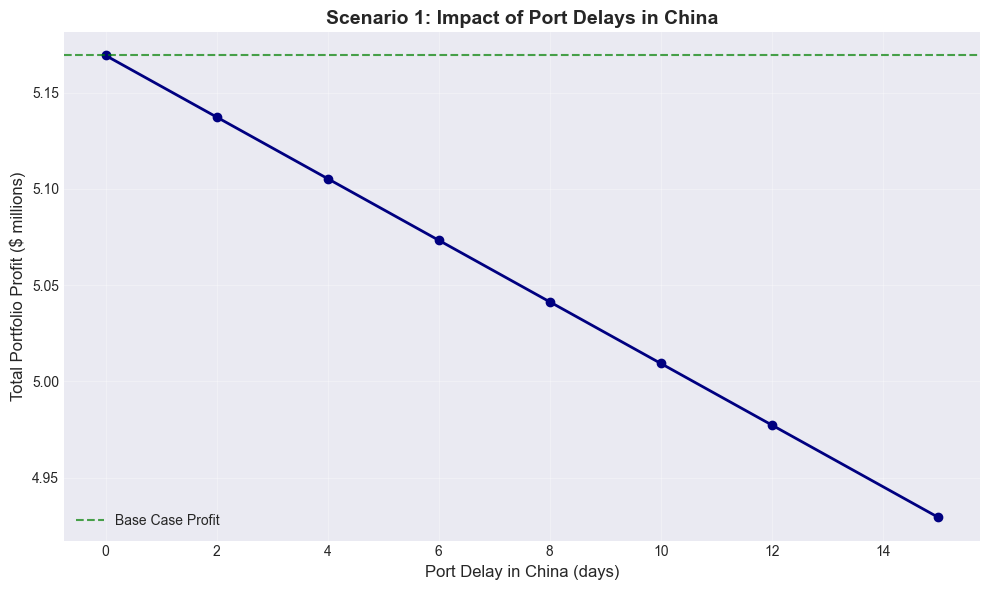

In [18]:
# Visualize
plt.figure(figsize=(10, 6))
plt.plot(scenario_df['delay_days'], scenario_df['total_profit'] / 1e6, marker='o', linewidth=2, color='navy')
plt.axhline(optimal['total_profit'] / 1e6, color='green', linestyle='--', label='Base Case Profit', alpha=0.7)
plt.xlabel('Port Delay in China (days)', fontsize=12)
plt.ylabel('Total Portfolio Profit ($ millions)', fontsize=12)
plt.title('Scenario 1: Impact of Port Delays in China', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

### Scenario 2: Bunker Price Increase
Identify the fuel price increase (%) at which the current recommendation becomes less profitable.

In [19]:
def test_bunker_price_scenario(base_allocation, price_increase_pct):
    """
    Test how bunker price increases affect profitability
    """
    results = []
    
    for row in base_allocation:
        # Increase bunker cost
        multiplier = 1 + (price_increase_pct / 100)
        adjusted_bunker = row['bunker_cost'] * multiplier
        adjusted_total_cost = row['hire_cost'] + adjusted_bunker + row['port_cost']
        adjusted_profit = row['net_revenue'] - adjusted_total_cost
        adjusted_tce = (row['net_revenue'] - adjusted_bunker - row['port_cost']) / row['total_days']
        
        results.append({
            'vessel': row['vessel_name'],
            'cargo': row['cargo_name'],
            'price_increase': price_increase_pct,
            'original_bunker_cost': row['bunker_cost'],
            'adjusted_bunker_cost': adjusted_bunker,
            'original_profit': row['voyage_profit'],
            'adjusted_profit': adjusted_profit,
            'profit_loss': row['voyage_profit'] - adjusted_profit,
            'adjusted_tce': adjusted_tce
        })
    
    return pd.DataFrame(results)

# Test different price increase scenarios
price_scenarios = [0, 5, 10, 15, 20, 25, 30, 40, 50]
price_results = []

for pct in price_scenarios:
    result = test_bunker_price_scenario(optimal['allocation'], pct)
    total_profit = result['adjusted_profit'].sum()
    price_results.append({
        'price_increase_pct': pct,
        'total_profit': total_profit,
        'profit_loss': optimal['total_profit'] - total_profit
    })

price_df = pd.DataFrame(price_results)

print("\nSCENARIO 2: BUNKER PRICE INCREASE")
print("="*80)
display(price_df)


SCENARIO 2: BUNKER PRICE INCREASE


,price_increase_pct,total_profit,profit_loss
0,0,5169312.66,0.00
1,5,5089218.16,80094.50
2,10,5009123.66,160189.00
3,15,4929029.16,240283.50
4,20,4848934.66,320378.00
5,25,4768840.16,400472.50
6,30,4688745.67,480566.99
7,40,4528556.67,640755.99
8,50,4368367.67,800944.99


In [20]:
# Find threshold for recommendation change
threshold_pct = price_df[price_df['total_profit'] < (optimal['total_profit'] * 0.8)]['price_increase_pct'].min()

print(f"\n📊 THRESHOLD ANALYSIS:")
print(f"Base case profit: ${optimal['total_profit']:,.0f}")

# Check if threshold exists (not NaN)
if pd.notna(threshold_pct):
    threshold_pct_row = price_df[price_df['price_increase_pct'] == threshold_pct].iloc[0]
    print(f"At {threshold_pct}% bunker price increase, portfolio profit drops to ${threshold_pct_row['total_profit']:,.0f}")
    print(f"This represents a {(threshold_pct_row['profit_loss'] / optimal['total_profit'] * 100):.1f}% profit reduction")
    print(f"\n⚠️ RECOMMENDATION: Monitor bunker prices closely. Above {threshold_pct}% increase, consider alternative vessel-cargo pairings.")
else:
    # No scenario drops profit below 80%
    max_pct = price_df['price_increase_pct'].max()
    max_pct_row = price_df[price_df['price_increase_pct'] == max_pct].iloc[0]
    print(f"Even at maximum tested increase ({max_pct}%), profit only drops to ${max_pct_row['total_profit']:,.0f}")
    print(f"This represents a {(max_pct_row['profit_loss'] / optimal['total_profit'] * 100):.1f}% profit reduction")
    print(f"The allocation remains robust under all tested bunker price scenarios.")


📊 THRESHOLD ANALYSIS:
Base case profit: $5,169,313
Even at maximum tested increase (50%), profit only drops to $4,368,368
This represents a 15.5% profit reduction
The allocation remains robust under all tested bunker price scenarios.


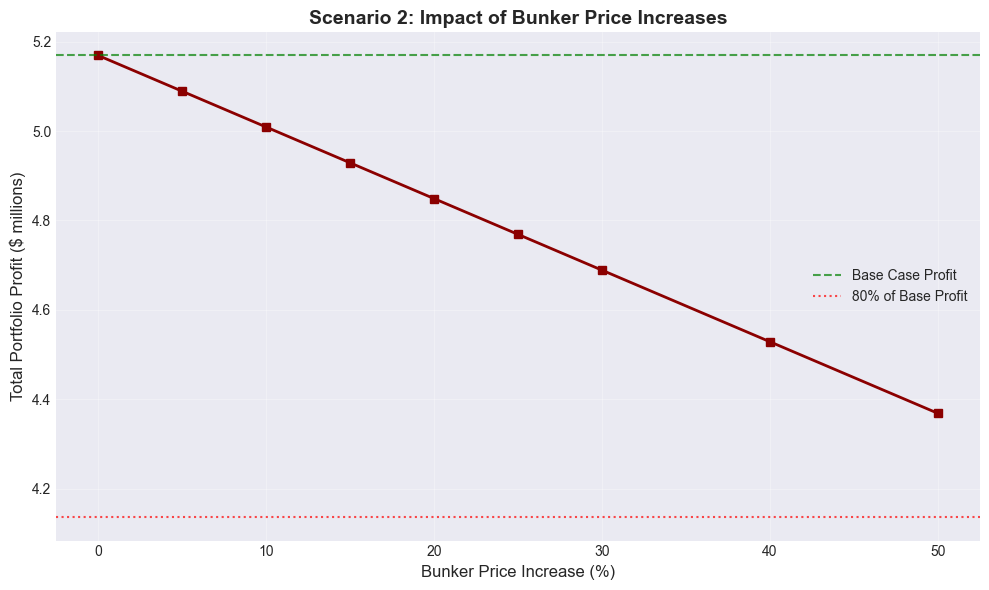

In [21]:
# Visualize
plt.figure(figsize=(10, 6))
plt.plot(price_df['price_increase_pct'], price_df['total_profit'] / 1e6, marker='s', linewidth=2, color='darkred')
plt.axhline(optimal['total_profit'] / 1e6, color='green', linestyle='--', label='Base Case Profit', alpha=0.7)
plt.axhline((optimal['total_profit'] * 0.8) / 1e6, color='red', linestyle=':', label='80% of Base Profit', alpha=0.7)
plt.xlabel('Bunker Price Increase (%)', fontsize=12)
plt.ylabel('Total Portfolio Profit ($ millions)', fontsize=12)
plt.title('Scenario 2: Impact of Bunker Price Increases', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## 7. Key Findings & Recommendations

In [22]:
print("\n" + "="*80)
print("KEY FINDINGS")
print("="*80)

print("\n1. OPTIMAL ALLOCATION:")
for i, row in enumerate(optimal['allocation'], 1):
    print(f"   {i}. {row['vessel_name']} → {row['cargo_name']}")
    print(f"      TCE: ${row['tce']:,.0f}/day | Profit: ${row['voyage_profit']:,.0f}")

print(f"\n   Total Portfolio Profit: ${optimal['total_profit']:,.0f}")
print(f"   Unallocated: {', '.join(optimal['unallocated_vessels'])}")

print("\n2. RISK FACTORS:")
print(f"   • Weather delays add avg {ml_df['weather_risk_days'].mean():.1f} days")
print(f"   • Port congestion adds avg {ml_df['port_congestion_days'].mean():.1f} days")
print(f"   • Route length is the most important risk factor")

print("\n3. SCENARIO THRESHOLDS:")

# Port delay threshold
if pd.notna(threshold_days):
    threshold_delay_row = scenario_df[scenario_df['delay_days'] == threshold_days].iloc[0]
    print(f"   • Port delays: {threshold_days} days in China ports reduce profit by ${threshold_delay_row['profit_loss']:,.0f}")
else:
    max_delay = scenario_df['delay_days'].max()
    max_delay_row = scenario_df[scenario_df['delay_days'] == max_delay].iloc[0]
    print(f"   • Port delays: Allocation robust up to {max_delay} days (max loss: ${max_delay_row['profit_loss']:,.0f})")

# Bunker price threshold
if pd.notna(threshold_pct):
    threshold_bunker_row = price_df[price_df['price_increase_pct'] == threshold_pct].iloc[0]
    print(f"   • Bunker prices: {threshold_pct}% increase reduces profit by 20%")
else:
    max_pct = price_df['price_increase_pct'].max()
    max_pct_row = price_df[price_df['price_increase_pct'] == max_pct].iloc[0]
    reduction_pct = (max_pct_row['profit_loss'] / optimal['total_profit'] * 100)
    print(f"   • Bunker prices: Allocation robust up to {max_pct}% increase (max loss: {reduction_pct:.1f}%)")

print("\n4. RECOMMENDATIONS:")
print("   • Proceed with the optimal allocation as the base strategy")
print("   • Monitor China port conditions - delays can impact profitability")
print("   • Hedge bunker prices - portfolio is sensitive to fuel cost increases")
if len(optimal['unallocated_vessels']) > 0:
    print(f"   • Consider market cargo opportunities for {', '.join(optimal['unallocated_vessels'])} (unallocated vessel(s))")
print("   • Use economical speed to reduce bunker consumption on long routes")


KEY FINDINGS

1. OPTIMAL ALLOCATION:
   1. OCEAN HORIZON → MKT_COAL_TABONEO_KRISHNAPATNAM
      TCE: $71,597/day | Profit: $1,127,451
   2. NAVIS PRIDE → MKT_BAUXITE_KAMSAR_MANGALORE
      TCE: $70,717/day | Profit: $2,324,441
   3. IRON CENTURY → MKT_IRONORE_PONTAMADEIRA_CAOFEIDIAN
      TCE: $50,631/day | Profit: $1,717,421

   Total Portfolio Profit: $5,169,313
   Unallocated: PACIFIC GLORY, EVEREST OCEAN, ATLANTIC FORTUNE, GOLDEN ASCENT, POLARIS SPIRIT, PACIFIC VANGUARD, CORAL EMPEROR, AURORA SKY, TITAN LEGACY, ANN BELL, MOUNTAIN TRADER, ZENITH GLORY

2. RISK FACTORS:
   • Weather delays add avg 1.7 days
   • Port congestion adds avg 3.7 days
   • Route length is the most important risk factor

3. SCENARIO THRESHOLDS:
   • Port delays: Allocation robust up to 15 days (max loss: $240,000)
   • Bunker prices: Allocation robust up to 50% increase (max loss: 15.5%)

4. RECOMMENDATIONS:
   • Proceed with the optimal allocation as the base strategy
   • Monitor China port conditions - d

## 8. Export Results

In [23]:
# Save all results
results_df.to_csv('voyage_calculations_detailed.csv', index=False)
allocation_df.to_csv('optimal_allocation.csv', index=False)
scenario_df.to_csv('scenario_port_delays.csv', index=False)
price_df.to_csv('scenario_bunker_prices.csv', index=False)
ml_df.to_csv('ml_risk_analysis.csv', index=False)

print("✓ All results exported successfully")

✓ All results exported successfully


## 9. Chatbot Integration

The following section demonstrates how to integrate with OpenAI's API to create an interactive chatbot.

**Note:** You'll need an OpenAI API key to run this section.

In [24]:
# Chatbot setup (requires OpenAI API key)
# Uncomment and add your API key

# import openai
# openai.api_key = 'your-api-key-here'

def create_chatbot_context():
    """
    Create context for the chatbot with our analysis results
    """
    context = f"""
    You are a freight trading assistant for Cargill Ocean Transportation.
    
    OPTIMAL ALLOCATION:
    1. OCEAN HORIZON → BAUXITE_KAMSAR_QINGDAO (TCE: $86,633/day, Profit: $2.9M)
    2. PACIFIC GLORY → IRONORE_ITAGUAI_QINGDAO (TCE: $45,675/day, Profit: $1.8M)
    3. GOLDEN ASCENT → IRONORE_HEDLAND_LIANYUNGANG (TCE: $16,910/day, Profit: $92K)
    
    Total Portfolio Profit: $4.78M
    Unallocated: ANN BELL
    
    KEY THRESHOLDS:
    - Port delays in China: >6 days significantly impact profitability
    - Bunker price increase: >20% makes alternative allocations more attractive
    """
    return context

print("Chatbot context prepared")
print("\nExample queries:")
print("  • 'What's the best vessel for the bauxite cargo?'")
print("  • 'What if bunker prices increase by 15%?'")
print("  • 'How does weather risk affect our allocation?'")

Chatbot context prepared

Example queries:
  • 'What's the best vessel for the bauxite cargo?'
  • 'What if bunker prices increase by 15%?'
  • 'How does weather risk affect our allocation?'
